# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [34]:
import warnings
import numpy as np
import numpy.random as npr
import pandas as pd
import re
from collections import Counter
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn.apionly as sns

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
# fix labels so that it's consistent with PCAWG_wgs_mut's
nonPCAWG_wgs_mut.columns = [i if "AdenoCa" not in i else i.replace("AdenoCa", "AdenoCA") for i in nonPCAWG_wgs_mut.columns]
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCA::pfg316T,Stomach-AdenoCA::pfg317T,Stomach-AdenoCA::pfg344T,Stomach-AdenoCA::pfg373T,Stomach-AdenoCA::pfg375T,Stomach-AdenoCA::pfg378T,Stomach-AdenoCA::pfg398T,Stomach-AdenoCA::pfg413T,Stomach-AdenoCA::pfg416T,Stomach-AdenoCA::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [175]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
# fix labels so that it's consistent with WGS's
TCGA_wes_mut.columns = [i if "AdenoCa" not in i else i.replace("AdenoCa", "AdenoCA") for i in TCGA_wes_mut.columns]
TCGA_wes_mut.columns = [i if "Testis-Ca" not in i else i.replace("Testis-Ca", "Testis-CA") for i in TCGA_wes_mut.columns]
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
# fix labels so that it's consistent with WGS's
other_wes_mut.columns = [i if "AdenoCa" not in i else i.replace("AdenoCa", "AdenoCA") for i in other_wes_mut.columns]
other_wes_mut.columns = [i if "Testis-Ca" not in i else i.replace("Testis-Ca", "Testis-CA") for i in other_wes_mut.columns]
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Data cleanup and train-test split

In [43]:
def normalize(data, axis=1):
    """
    Normalize DataFrame
    
    input
        data: DataFrame; data to normalize
        axis: int; axis on which normalization is done
        
    return
        normalized: DataFrame; normalized data
    """
    normalized = data.div(data.sum(axis=axis), axis=1-axis)
    
    return normalized

def construct_dataset(mutations, activities=None, subtypes=True, sample_cutoff=10, six_channels=False, types_to_drop=None,
                     normalization=True):
    """
    input
        mutations: mutation count dataset (e.g. PCAWG_wgs_mut)
        activities: sample mutation signature activities (e.g. PCAWG_wgs_act)
                        Adds signature activities column-wise to the final dataset
        subtypes: boolean indicating whether or not to use cancer subtypes instead of cancer types
        sample_cutoff: number indicating how many (at least) samples need to be present to be included in the final dataset
        six_channels: boolean indicating whether to construct reduced 6-channel (summed over context)
                        or full 96-channel dataset
        types_to_drop: a list of cancer types to drop manually (e.g. removing cancers that are hard to classify)
        normalization: boolean; if True, for each row, normalize mutation counts and signature activities if applicable,
                    and add a column for the number of mutations
        
    return
        data: cleaned-up data
    """
    
    # Either construct 6-channel of full 96-channel dataset
    if six_channels:
        channels6 = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
        temp = {}
        for c in channels6:
            new_row = np.zeros(mutations.shape[1]-2)
            for row in mutations.itertuples(index=True, name='Pandas'):
                if row[1] == c:
                    new_row += row[3:]
            temp[c] = new_row

        data = pd.DataFrame(data=temp).T
        data.columns = mutations.columns[2:]
        data = data.T
    else:
        data = mutations.iloc[:, 2:].T
        data.columns = mutations["Mutation type"] + "_" + mutations["Trinucleotide"]

    # normalize mutation counts
    if normalization:
        n_mutations = data.sum(axis=1)
        data = normalize(data, axis=1)
        data['n_mutations'] = n_mutations/n_mutations.sum()
    
    # Add activities if they are provided
    if activities is not None:
        activities.index = activities["Cancer Types"] + "::" + activities["Sample Names"]
        sig_accuracy = activities.iloc[:, 2]
        activities = activities.iloc[:, 3:]
        if normalization:
            activities = normalize(activities)
        data = data.join(activities).join(sig_accuracy)
    
    # Set label depending on 'subtype' parameter
    # Split "::" for cancer subtypes, "-" for general cancer types
    if subtypes:
        split = "::"
    else:
        split = "-"
    
    labels = []
    for sample_name in mutations.columns.values[2:]:
        if "::" in sample_name.split(split)[0]:
            labels.append(sample_name.split(split)[0].split("::")[0])
        else:
            labels.append(sample_name.split(split)[0])
    data.index = labels
    
    # Remove samples of cancer types that appear less than n=sample_cutoff times
    to_drop_types = [x for x in labels if Counter(labels)[x] <= sample_cutoff]

    if types_to_drop is not None:
        to_drop_types += types_to_drop
    
    print("Dropping:", sorted(set(to_drop_types)))
    
    to_drop_samples = [sample_name for sample_name in data.index.values if sample_name.split(split)[0] in to_drop_types
                      or sample_name.split(split)[0].split("::")[0] in to_drop_types]
    data = data.drop(to_drop_samples)
    
    return data

# Data generation

In [177]:
datasets = {}

## firstly datasets of WGS
# data with non-subtype labeling and 96 channels
datasets["PCAWG"] = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["PCAWG_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=False,
                                               sample_cutoff=50)
# other indicates non-PCAWG WGS data
datasets["Other"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["Other_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=False, six_channels=False,
                                               sample_cutoff=50)
# WGS indicates TCAWG and non-PCAWG WGS combined
datasets["WGS"] = pd.concat([datasets["PCAWG"], datasets["Other"]])
datasets["WGS_with_act"] = pd.concat([datasets["PCAWG_with_act"], datasets["Other_with_act"]])


# data with subtype labeling and 96 channels
datasets["PCAWG_sub"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["PCAWG_sub_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=False,
                                                   sample_cutoff=50)
datasets["Other_sub"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["Other_sub_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True, six_channels=False,
                                                   sample_cutoff=50)
datasets["WGS_sub"] = pd.concat([datasets["PCAWG_sub"], datasets["Other_sub"]])
datasets["WGS_sub_with_act"] = pd.concat([datasets["PCAWG_sub_with_act"], datasets["Other_sub_with_act"]])


# data with non-subtype labeling and 6 channels
datasets["PCAWG_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=False, six_channels=True,
                                                       sample_cutoff=50)
datasets["Other_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["Other_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=False,
                                                       six_channels=True, sample_cutoff=50)
datasets["WGS_sixchan"] = pd.concat([datasets["PCAWG_sixchan"], datasets["Other_sixchan"]])
datasets["WGS_sixchan_with_act"] = pd.concat([datasets["PCAWG_sixchan_with_act"], datasets["Other_sixchan_with_act"]])


# data with subtype labeling and 6 channels
datasets["PCAWG_sub_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sub_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=True,
                                                           sample_cutoff=50)
datasets["Other_sub_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["Other_sub_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True,
                                                           six_channels=True, sample_cutoff=50)
datasets["WGS_sub_sixchan"] = pd.concat([datasets["PCAWG_sub_sixchan"], datasets["Other_sub_sixchan"]])
datasets["WGS_sub_sixchan_with_act"] = pd.concat([datasets["PCAWG_sub_sixchan_with_act"],
                                                  datasets["Other_sub_sixchan_with_act"]])




## then datasets with WES
# data with non-subtype labeling and 96 channels
datasets["TCGA"] = construct_dataset(TCGA_wes_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["TCGA_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=False, six_channels=False,
                                              sample_cutoff=50)
# Other_WES indicate non-TCGA WES data
datasets["Other_WES"] = construct_dataset(other_wes_mut, subtypes=False, six_channels=False, sample_cutoff=50)
datasets["Other_WES_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=False, six_channels=False,
                                                   sample_cutoff=50)
# WES indicates TCGA and non-TCGA WES data combined
datasets["WES"] = pd.concat([datasets["TCGA"], datasets["Other_WES"]])
datasets["WES_with_act"] = pd.concat([datasets["TCGA_with_act"], datasets["Other_WES_with_act"]])


# data with subtype labeling and 96 channels
datasets["TCGA_sub"] = construct_dataset(TCGA_wes_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["TCGA_sub_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=True, six_channels=False,
                                                  sample_cutoff=50)
datasets["Other_WES_sub"] = construct_dataset(other_wes_mut, subtypes=True, six_channels=False, sample_cutoff=50)
datasets["Other_WES_sub_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=True, six_channels=False,
                                                       sample_cutoff=50)
datasets["WES_sub"] = pd.concat([datasets["TCGA_sub"], datasets["Other_WES_sub"]])
datasets["WES_sub_with_act"] = pd.concat([datasets["TCGA_sub_with_act"], datasets["Other_WES_sub_with_act"]])


# data with non-subtype labeling and 6 channels
datasets["TCGA_sixchan"] = construct_dataset(TCGA_wes_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["TCGA_sixchan_with_act"] = construct_dataset(TCGA_wes_mut, TCGA_wes_act, subtypes=False, six_channels=True,
                                                       sample_cutoff=50)
datasets["Other_WES_sixchan"] = construct_dataset(other_wes_mut, subtypes=False, six_channels=True, sample_cutoff=50)
datasets["Other_WES_sixchan_with_act"] = construct_dataset(other_wes_mut, other_wes_act, subtypes=False,
                                                       six_channels=True, sample_cutoff=50)
datasets["WES_sixchan"] = pd.concat([datasets["TCGA_sixchan"], datasets["Other_WES_sixchan"]])
datasets["WES_sixchan_with_act"] = pd.concat([datasets["TCGA_sixchan_with_act"], datasets["Other_WES_sixchan_with_act"]])


# data with subtype labeling and 6 channels
datasets["PCAWG_sub_sixchan"] = construct_dataset(PCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["PCAWG_sub_sixchan_with_act"] = construct_dataset(PCAWG_wgs_mut, PCAWG_wgs_act, subtypes=True, six_channels=True,
                                                           sample_cutoff=50)
datasets["Other_sub_sixchan"] = construct_dataset(nonPCAWG_wgs_mut, subtypes=True, six_channels=True, sample_cutoff=50)
datasets["Other_sub_sixchan_with_act"] = construct_dataset(nonPCAWG_wgs_mut, nonPCAWG_wgs_act, subtypes=True,
                                                           six_channels=True, sample_cutoff=50)
datasets["WGS_sub_sixchan"] = pd.concat([datasets["PCAWG_sub_sixchan"], datasets["Other_sub_sixchan"]])
datasets["WGS_sub_sixchan_with_act"] = pd.concat([datasets["PCAWG_sub_sixchan_with_act"],
                                                  datasets["Other_sub_sixchan_with_act"]])

Dropping: ['Biliary', 'Bladder', 'Cervix', 'SoftTissue', 'Thy']
Dropping: ['Biliary', 'Bladder', 'Cervix', 'SoftTissue', 'Thy']
Dropping: ['ALL', 'AML', 'Blood', 'Bone', 'ColoRect', 'Eso', 'Eye', 'Kidney', 'Lung', 'Ovary']
Dropping: ['ALL', 'AML', 'Blood', 'Bone', 'ColoRect', 'Eso', 'Eye', 'Kidney', 'Lung', 'Ovary']
Dropping: ['Biliary-AdenoCA', 'Bladder-TCC', 'Bone-Benign', 'Bone-Epith', 'Bone-Osteosarc', 'Breast-DCIS', 'Breast-LobularCA', 'CNS-GBM', 'CNS-Oligo', 'Cervix-AdenoCA', 'Cervix-SCC', 'Kidney-ChRCC', 'Lung-AdenoCA', 'Lung-SCC', 'Myeloid-AML', 'Myeloid-MDS', 'SoftTissue-Leiomyo', 'SoftTissue-Liposarc', 'Thy-AdenoCA']
Dropping: ['Biliary-AdenoCA', 'Bladder-TCC', 'Bone-Benign', 'Bone-Epith', 'Bone-Osteosarc', 'Breast-DCIS', 'Breast-LobularCA', 'CNS-GBM', 'CNS-Oligo', 'Cervix-AdenoCA', 'Cervix-SCC', 'Kidney-ChRCC', 'Lung-AdenoCA', 'Lung-SCC', 'Myeloid-AML', 'Myeloid-MDS', 'SoftTissue-Leiomyo', 'SoftTissue-Liposarc', 'Thy-AdenoCA']
Dropping: ['ALL', 'AML', 'Blood-CMDI', 'Bone-can

In [60]:
def confusion_matrix_plot(cmat, labels, title=""):
    """
    input
        cmat: matrix from sklearn.metrics.confusion_matrix; confusion matrix to plot as heatmap
        labels: list; x and y axis labels
        title: string; optional title for plot
    return
        heatmap
    """
    
    cmat_p = pd.DataFrame(cmat)
    cmat_p = (cmat_p).astype('|S5').reset_index()
    cmat_norm = cmat / cmat.sum(axis=1)[:, np.newaxis]
    cmat_norm = np.round(cmat_norm * 100, decimals=1)
    cmat_norm = pd.DataFrame(cmat_norm)
    cmat_norm = (cmat_norm).astype('|S5').reset_index()
    
    newline = np.char.array(pd.DataFrame('\n', index=cmat_p.index, columns=cmat_norm.columns))
    percentage = np.char.array(pd.DataFrame('%', index=cmat_p.index, columns=cmat_norm.columns))
    
    cmat_p = np.char.array(cmat_p)
    cmat_norm = np.char.array(cmat_norm)
    
    annotation = pd.DataFrame(cmat_p + newline + cmat_norm + percentage)
    annotation = annotation.applymap(lambda x: x.decode('utf-8')) 
    annotation = annotation.drop(columns=[0])
    annotation = annotation.replace(to_replace="0\n0.0%", value="0")

    sns.set(rc={"figure.figsize":(13,13)})
    ax = plt.axes()
    sns.heatmap(cmat, annot=annotation, cbar=False, xticklabels=labels, yticklabels=labels, fmt="s")
    ax.set_title(title, fontsize=15)
    plt.yticks(rotation=0)
    plt.show()

# Random Forest

Accuracy:  0.8082191780821918
Mean Absolute Error: 1.5582191780821917
Mean Squared Error: 16.681506849315067
Root Mean Squared Error: 4.08430004398735


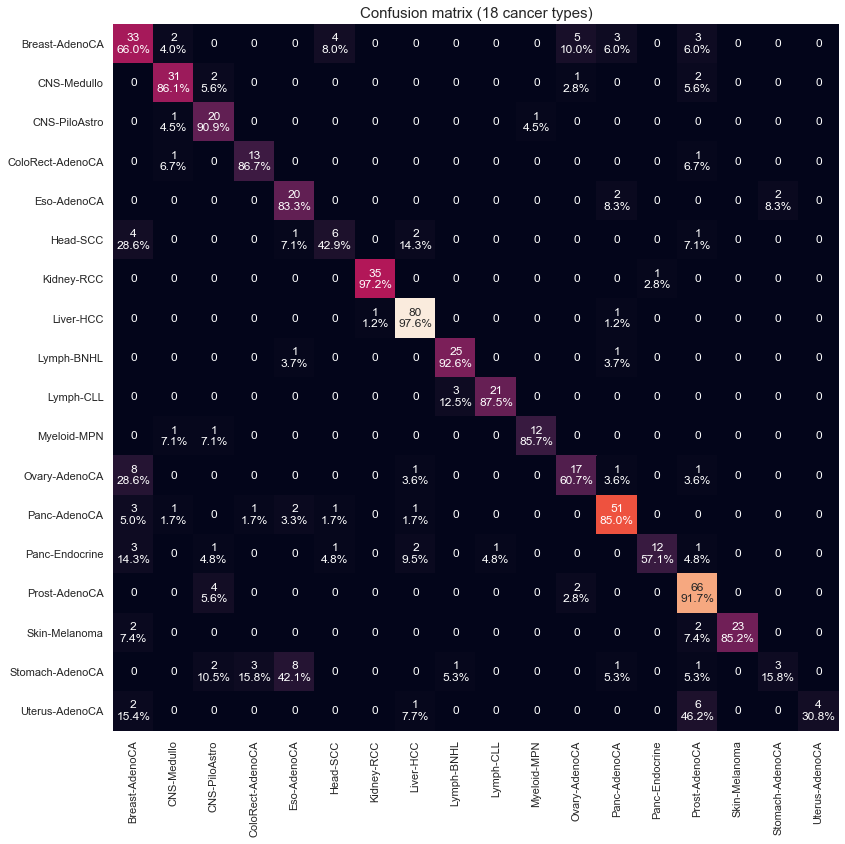

'\nimportances = rf.feature_importances_\nindices = np.argsort(importances)[::-1]\nplt.figure(figsize=(20,5))\nplt.title("Feature importances")\nplt.bar(range(x.shape[1]), importances[indices], color="r", align="center")\nplt.xticks(range(x.shape[1]), data.columns[indices], rotation=90)\nplt.show()\n'

In [91]:
x = np.array(data_pcawg)
y = np.array(data_pcawg.index.values)

# Convert labels to numbers
to_int = {}
y_labs = list(sorted(set(y)))
for i in range(len(y_labs)):
    to_int[y_labs[i]] = i
to_label = {x: y for y, x in to_int.items()}

y = [to_int[x] for x in y]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y)
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(train_x, train_y)

rf_predictions = rf.predict(test_x)
print("Accuracy: ", sum(rf_predictions == test_y)/len(test_y))
print("Mean Absolute Error:", metrics.mean_absolute_error(test_y, rf_predictions))
print("Mean Squared Error:", metrics.mean_squared_error(test_y, rf_predictions))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(test_y, rf_predictions)))

plot_labels = sorted(set([to_label[x] for x in y]))
cmat = metrics.confusion_matrix(test_y, rf_predictions)
confusion_matrix_plot(cmat, plot_labels, "Confusion matrix (" + str(len(set(y))) + " cancer types)")

"""
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x.shape[1]), data.columns[indices], rotation=90)
plt.show()
"""

# Support Vector Machine

In [111]:
def grid_search(X_train, y_train, kernel='rbf', return_val_acc=False):
    """
    Grid search to tune C for SVM
    
    input
        X_train: array-like, [n_samples, n_features]; input data for training
        y_train: array-like, [n_samples]; output data for training
        kernel: string, optional (default='rbf').
            Kernel to use in SVM; it must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable
    
    return
        best_C_gamma: best pair of C and gamma through grid search
    """
    param_list = [0.001, 0.01, 0.1, 1, 10, 100]
    best_score = 0
    
    if kernel=='linear':
        best_gamma = 'N/A'
        for C in param_list:
            model = LinearSVC(C=C)
            score = np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1))
            if score > best_score:
                best_score = score
                best_C = C
    
    else:
        for C in param_list:
            for gamma in param_list:
                model = SVC(C=C, gamma=gamma, kernel=kernel)
                score = np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1))
                if score > best_score:
                    best_score = score
                    best_C = C
                    best_gamma = gamma
    print("Grid Search Result")
    print("Validation Accuracy:", best_score)
    print("Best C:", best_C)
    print("Best gamma:", best_gamma)
    best_C_gamma = [best_C, best_gamma]
    
    if return_val_acc:
        return best_C_gamma, best_score
    else:
        return best_C_gamma

def SVM(X_train, X_test, y_train, y_test, C, gamma, kernel='rbf', return_y_pred=False, return_test_acc=False):
    """
    Train and test SVM algorithm
    
    input
        X_train: array-like, [n_samples, n_features]; input data for training
        X_test: array-like, [n_samples, n_features]; input data for testing
        y_train: array-like, [n_samples]; output data for training
        y_test: array-like, [n_samples]; output data for testing
        C: int; parameter C for SVM
        gamma: int; parameter gamma for SVM
        kernel: string, optional (default='rbf')
            Kernel to use in SVM; it must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable 
    
    return
        model: trained SVM model
    """
    if kernel=='linear':
        model = LinearSVC(C=C)
    
    else:
        model = SVC(C=C, gamma=gamma, kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    
    print("Test Accuracy:", score)
    
    if return_y_pred:
        if return_test_acc:
            return model, y_pred, score
        else:
            return model, y_pred
    
    else:
        if return_test_acc:
            return model, score
        else:
            return model

Here we try SVM with both linear and rbf kernels for PCAWG mutation profile data with non-subtype labeling and 96 channels below:

kernel: linear
Grid Search Result
Validation Accuracy: 0.7548340017375137
Best C: 100
Best gamma: N/A
Test Accuracy: 0.7977099236641222


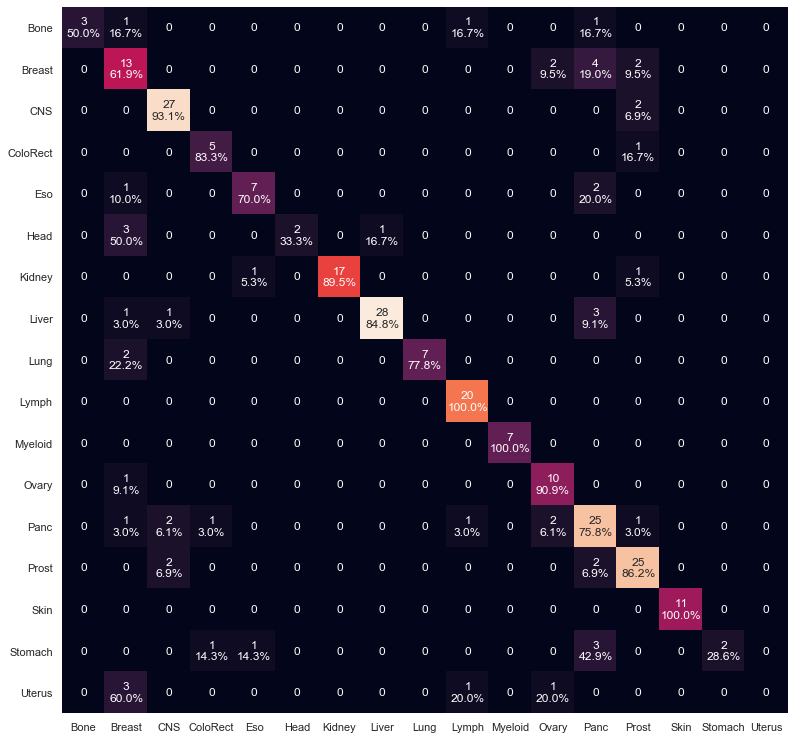


kernel: rbf
Grid Search Result
Validation Accuracy: 0.8312681093816503
Best C: 10
Best gamma: 100
Test Accuracy: 0.8396946564885496


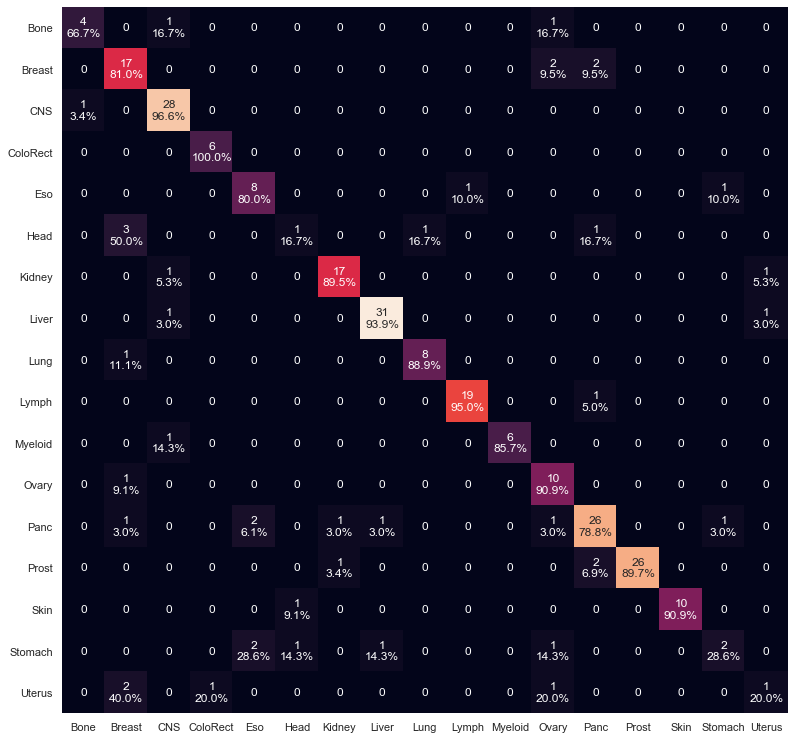

In [68]:
npr.seed(42)
kernels = ['linear', 'rbf']
data = datasets["PCAGW"]
for k in kernels:
    print("kernel:", k)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    # supress warnings when optimization doesn't converge, which often happens when kernel is linear
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        best_C_gamma = grid_search(X_train, y_train, kernel=k)
        _, y_pred = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel=k, return_y_pred=True)
        cmat = metrics.confusion_matrix(y_test, y_pred)
        label = np.unique(np.concatenate((y_test, y_pred)))
        confusion_matrix_plot(cmat, label)
        
    print("")

We intuitively guessed rbf kernel worked better than linear kernel, and it is consistent with the result above.  
As we have many different datasets to try algorithms on, we work only rbf kernel from now on.  
Firstly, we try to run the algorithm with rbf kernel on three datasets: PCAWG, other, and WGS (PCAWG and other combined).

PCAWG
Grid Search Result
Validation Accuracy: 0.8355006804233429
Best C: 10
Best gamma: 100
Test Accuracy: 0.851145038167939


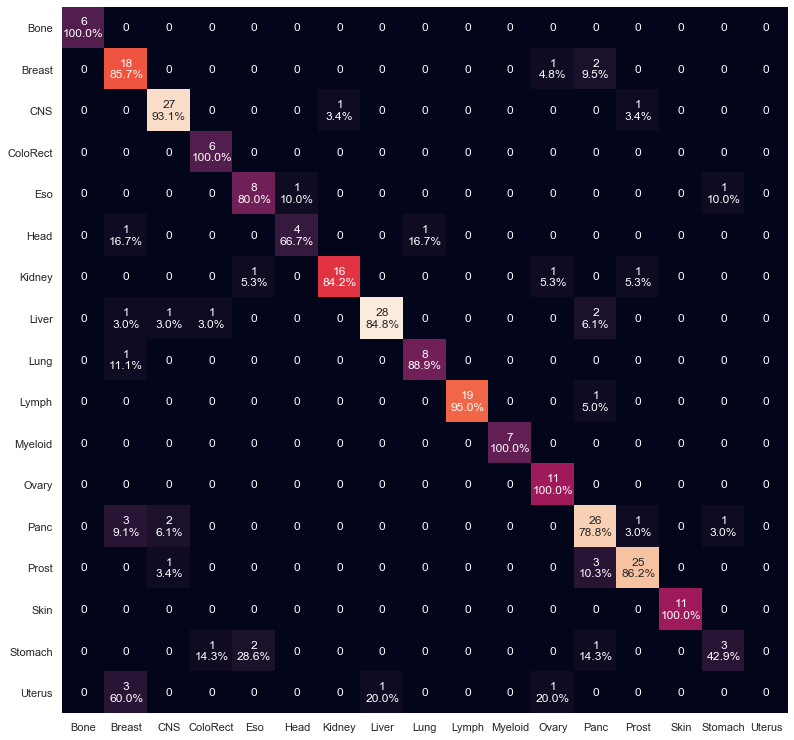


Other
Grid Search Result
Validation Accuracy: 0.7828807438213652
Best C: 100
Best gamma: 100
Test Accuracy: 0.7791411042944786


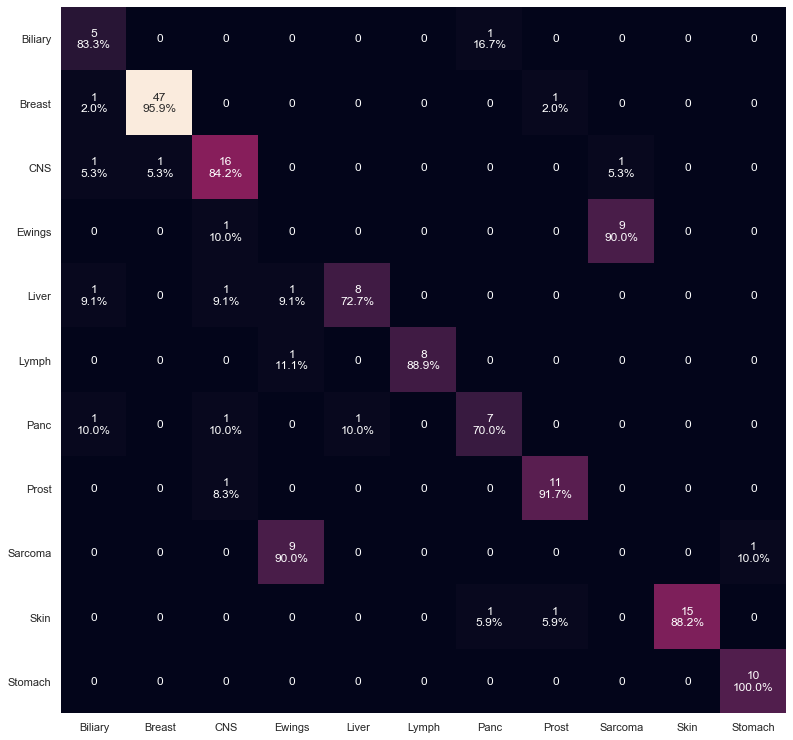


WGS
Grid Search Result
Validation Accuracy: 0.8090563304317742
Best C: 10
Best gamma: 100
Test Accuracy: 0.8117647058823529


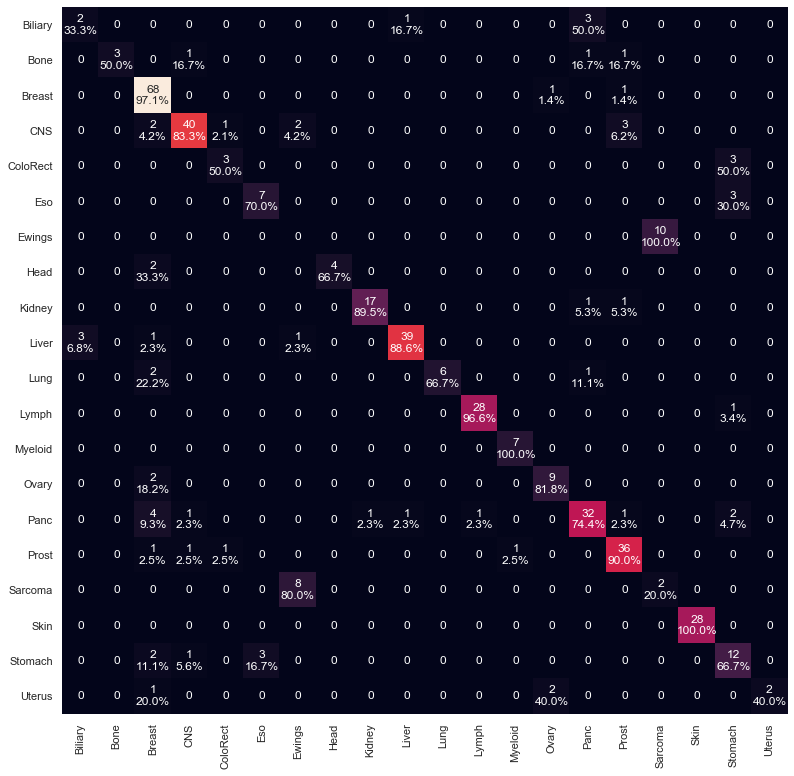

In [112]:
npr.seed(42)
dataset_names = ['PCAWG', 'Other', 'WGS']
cmats = {}
labels = {}
val_accs = {}
test_accs = {}
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    confusion_matrix_plot(cmats[name], labels[name])
        
    print("")

Comparing results from PCAWG and other, we can tell that PCAWG is a better dataset (for our classification problem) in general, presumably because other dataset has more noises than PCAWG dataset.  
So the question is whether adding other dataset to PCAWG dataset, we can improve classification.  
Since PCAWG and other has some unshared labels, we compare the classification accuracies for the shared labels for this question.  
It seems hard to decide if having additional data from other dataset would improve classification since difference is highly label dependent, although the overall accuracy is better with PCAWG dataset than with WGS dataset.  
For further analysis, we focus on both PCAWG and WGS dataset.  
  
Next, we consider adding signature activity data and see how it affects classification quality.

In [113]:
npr.seed(42)
dataset_names = ['PCAWG_with_act', 'WGS_with_act']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_with_act
Grid Search Result
Validation Accuracy: 0.8080241526525415
Best C: 100
Best gamma: 1
Test Accuracy: 0.8282442748091603

WGS_with_act
Grid Search Result
Validation Accuracy: 0.7789257864015571
Best C: 100
Best gamma: 10
Test Accuracy: 0.7929411764705883



PCAWG
Validation Accuracy: 0.8355006804233429
Test Accuracy: 0.851145038167939


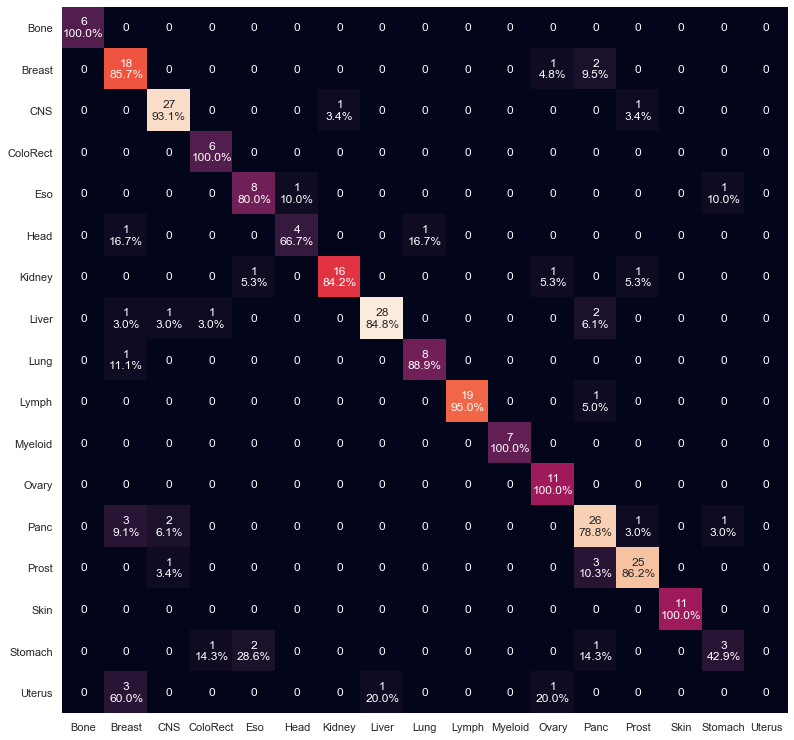

PCAWG_with_act
Validation Accuracy: 0.8080241526525415
Test Accuracy: 0.8282442748091603


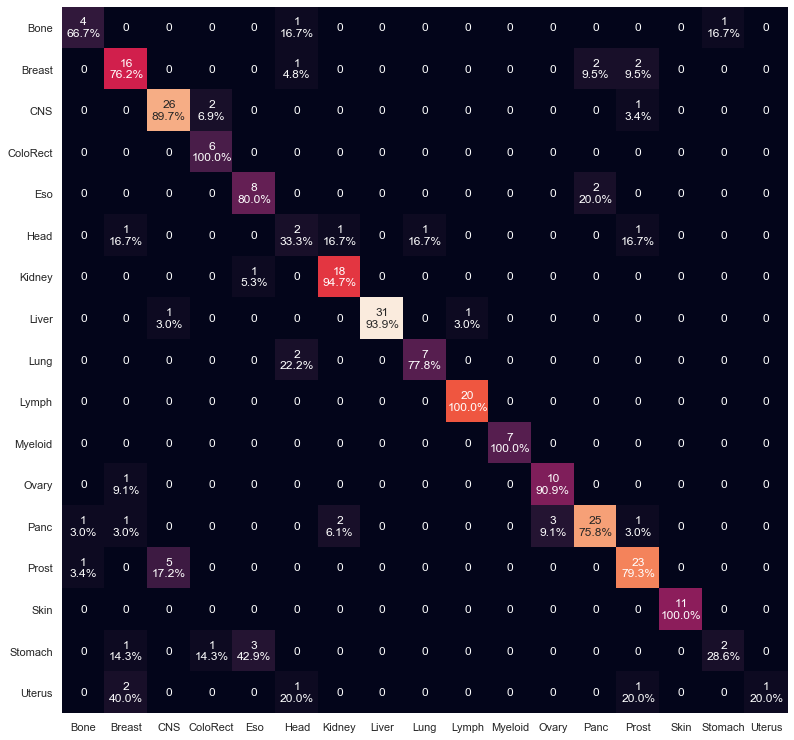

WGS
Validation Accuracy: 0.8090563304317742
Test Accuracy: 0.8117647058823529


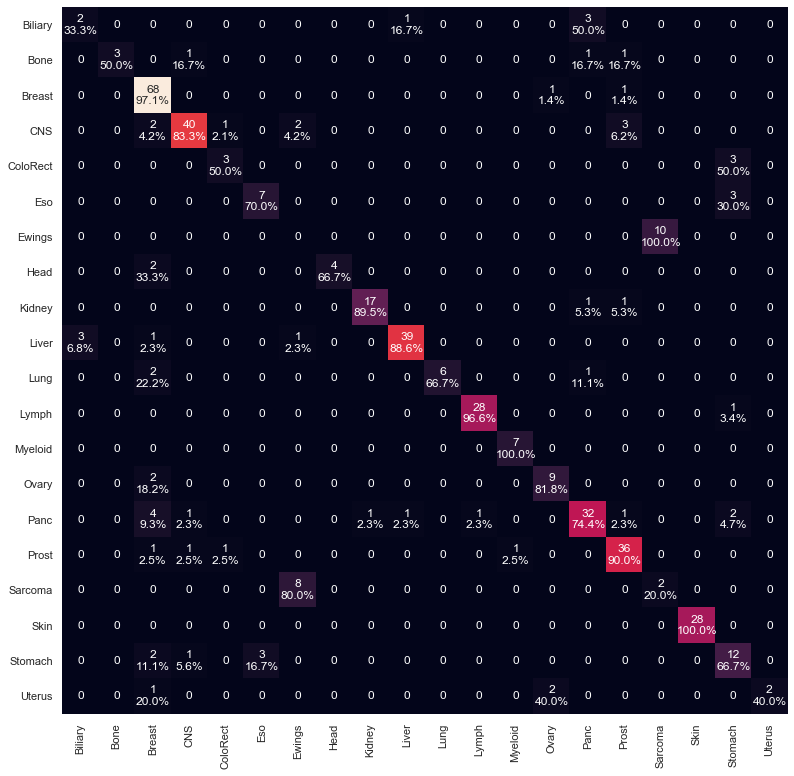

WGS_with_act
Validation Accuracy: 0.7789257864015571
Test Accuracy: 0.7929411764705883


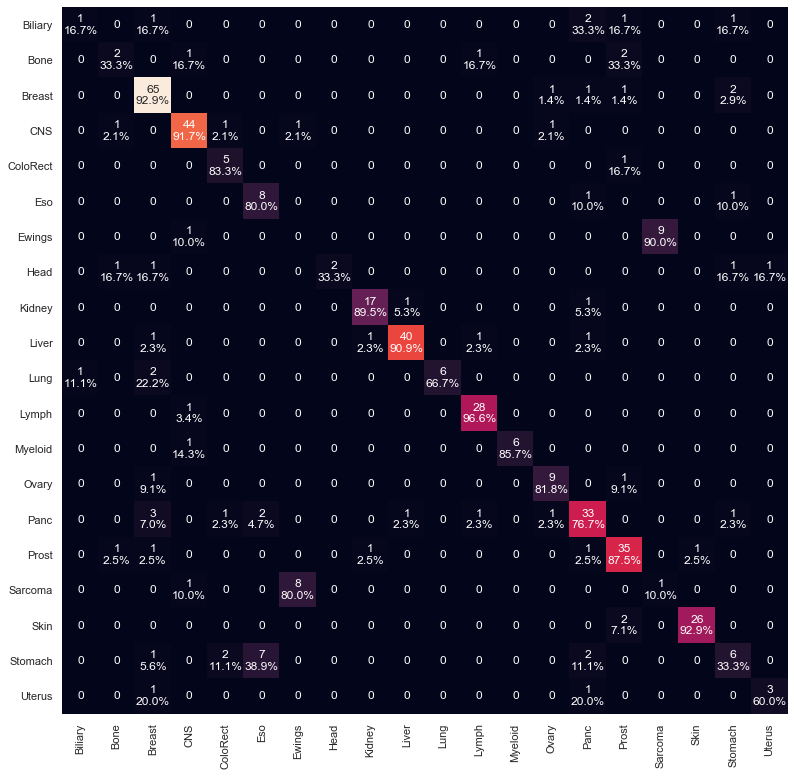

In [114]:
dataset_names = ['PCAWG', 'PCAWG_with_act', 'WGS', 'WGS_with_act']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

Interestingly, with both dataset PCAWG and WGS, adding signature activity data mostly deproved classifcation quality.  
For further analysis from now on, we do not use signature activity data together with mutational profile data.  
This could be due to high complexity of data and overfitting issue.  
  
Now, we look at whether using subtype label makes it harder to classify data than using non-subtype label.

In [156]:
npr.seed(42)
dataset_names = ['PCAWG_sub', 'WGS_sub']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_sub
Grid Search Result
Validation Accuracy: 0.8319515570754173
Best C: 100
Best gamma: 100
Test Accuracy: 0.8717948717948718

WGS_sub
Grid Search Result
Validation Accuracy: 0.7674786917521105
Best C: 100
Best gamma: 100
Test Accuracy: 0.7680412371134021



PCAWG
Validation Accuracy: 0.8355006804233429
Test Accuracy: 0.851145038167939


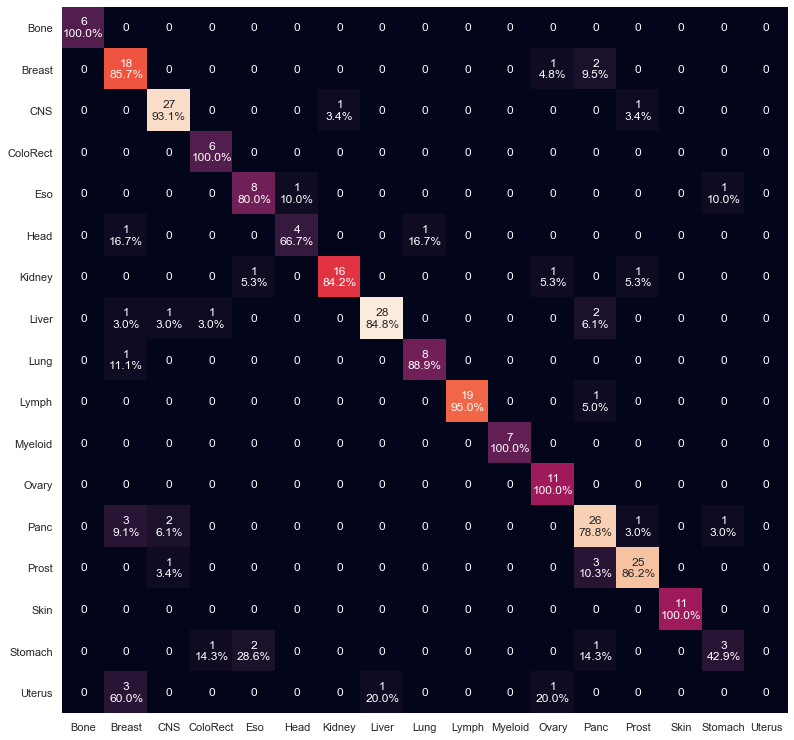

PCAWG_sub
Validation Accuracy: 0.8319515570754173
Test Accuracy: 0.8717948717948718


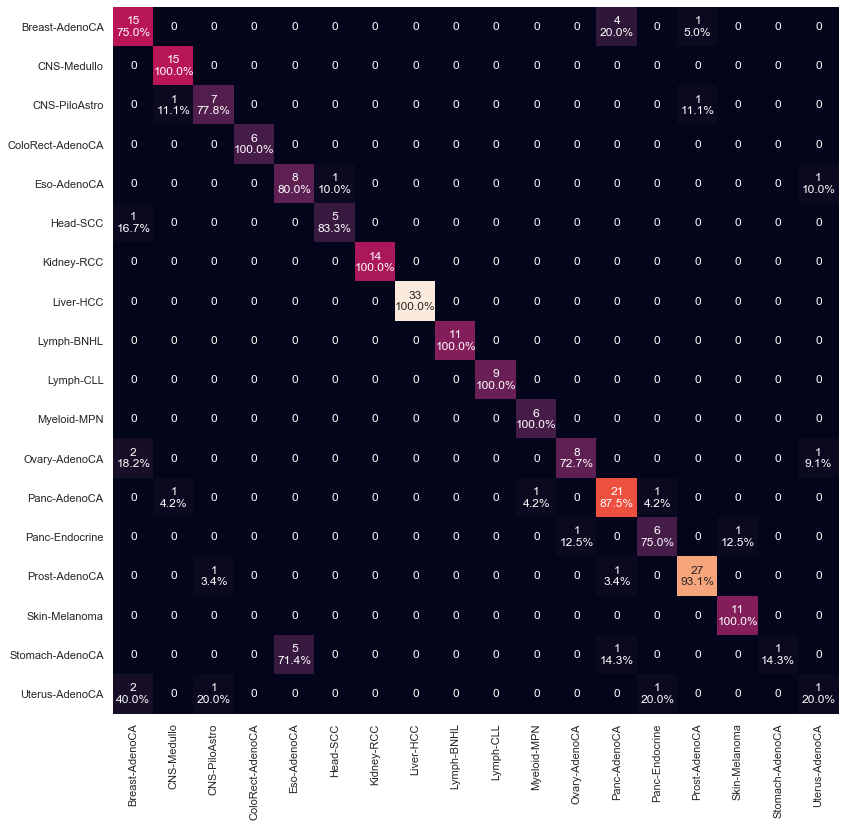

WGS
Validation Accuracy: 0.8090563304317742
Test Accuracy: 0.8117647058823529


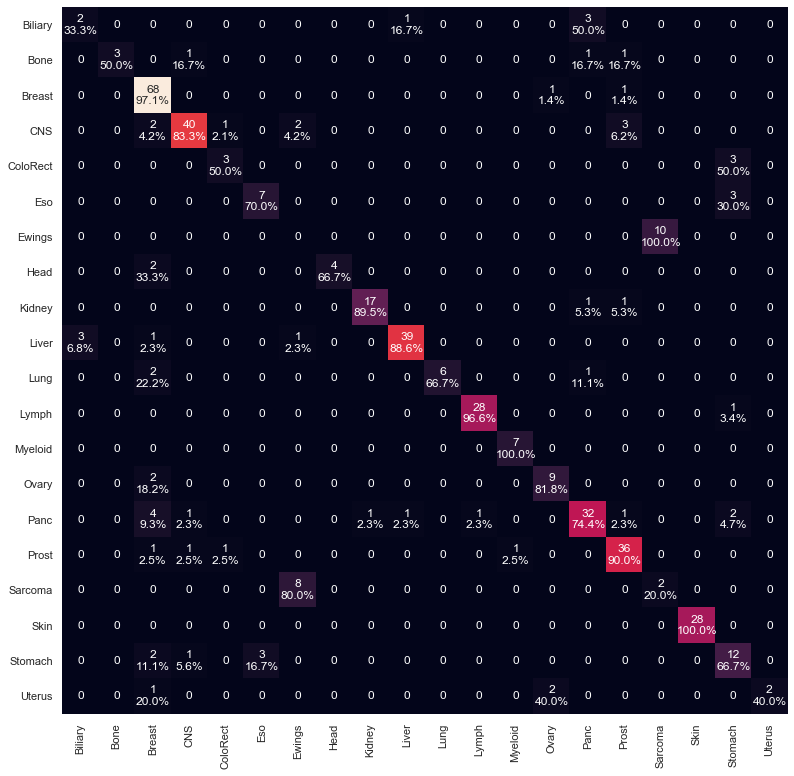

WGS_sub
Validation Accuracy: 0.7674786917521105
Test Accuracy: 0.7680412371134021


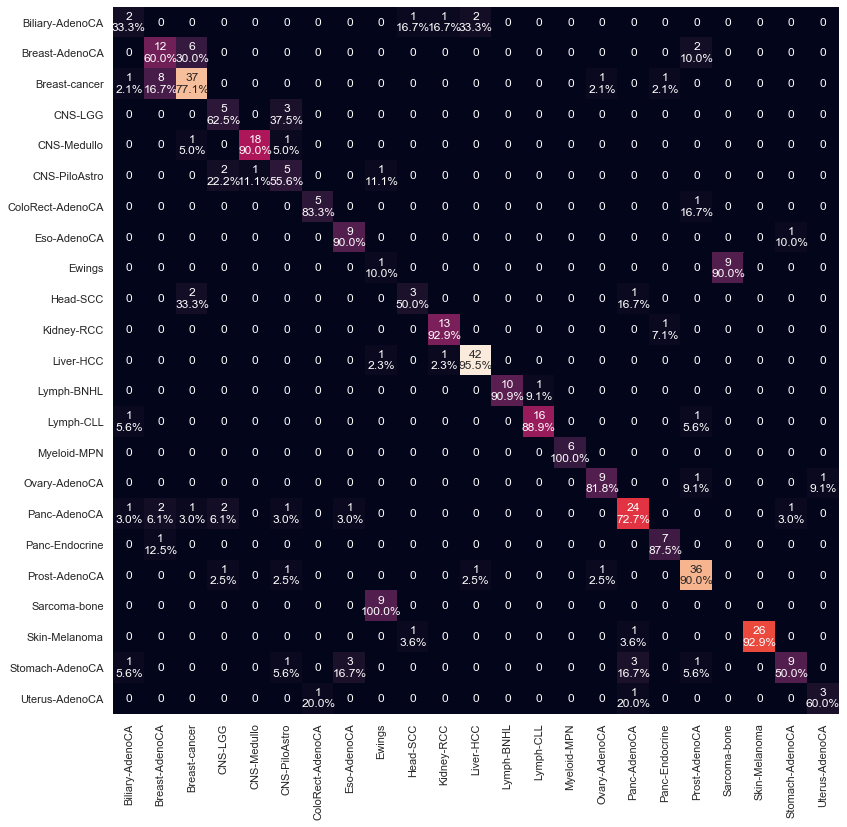

In [157]:
dataset_names = ['PCAWG', 'PCAWG_sub', 'WGS', 'WGS_sub']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

As illustrated above, subtype labels are harder to classify than non-subtype labels.  
From now on, we use subtype label since it would be more informative and harder to work on.  
  
Next, we check whether using 6 channels instead of 96 channels would improve classification.

In [158]:
npr.seed(42)
dataset_names = ['PCAWG_sub_sixchan', 'WGS_sub_sixchan']
for name in dataset_names:
    data = datasets[name]
    print(name)
    X_train, X_test, y_train, y_test = train_test_split(data, data.index.values, test_size=0.1, stratify=data.index.values)
    best_C_gamma, val_accs[name] = grid_search(X_train, y_train, kernel='rbf', return_val_acc=True)
    _, y_pred, test_accs[name] = SVM(X_train, X_test, y_train, y_test, best_C_gamma[0], best_C_gamma[1], kernel='rbf',
                                     return_y_pred=True, return_test_acc=True)
    cmats[name] = metrics.confusion_matrix(y_test, y_pred)
    labels[name] = np.unique(np.concatenate((y_test, y_pred)))
    print("")

PCAWG_sub_sixchan
Grid Search Result
Validation Accuracy: 0.6090699746852142
Best C: 100
Best gamma: 10
Test Accuracy: 0.6581196581196581

WGS_sub_sixchan
Grid Search Result
Validation Accuracy: 0.5418158616414974
Best C: 100
Best gamma: 10
Test Accuracy: 0.5180412371134021



PCAWG_sub
Validation Accuracy: 0.8319515570754173
Test Accuracy: 0.8717948717948718


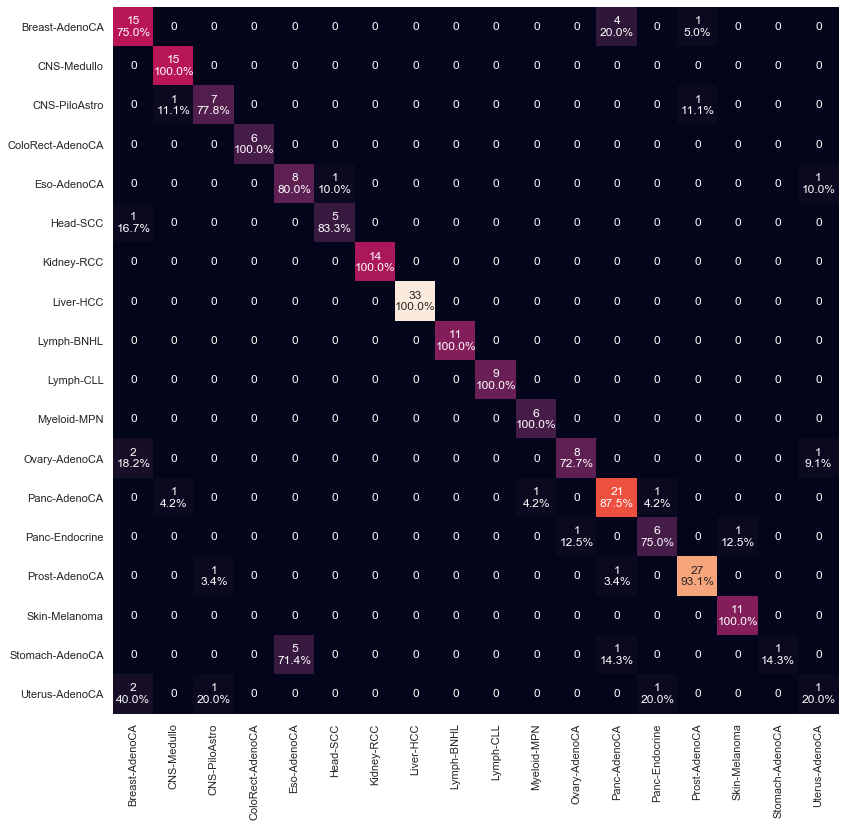

PCAWG_sub_sixchan
Validation Accuracy: 0.6090699746852142
Test Accuracy: 0.6581196581196581


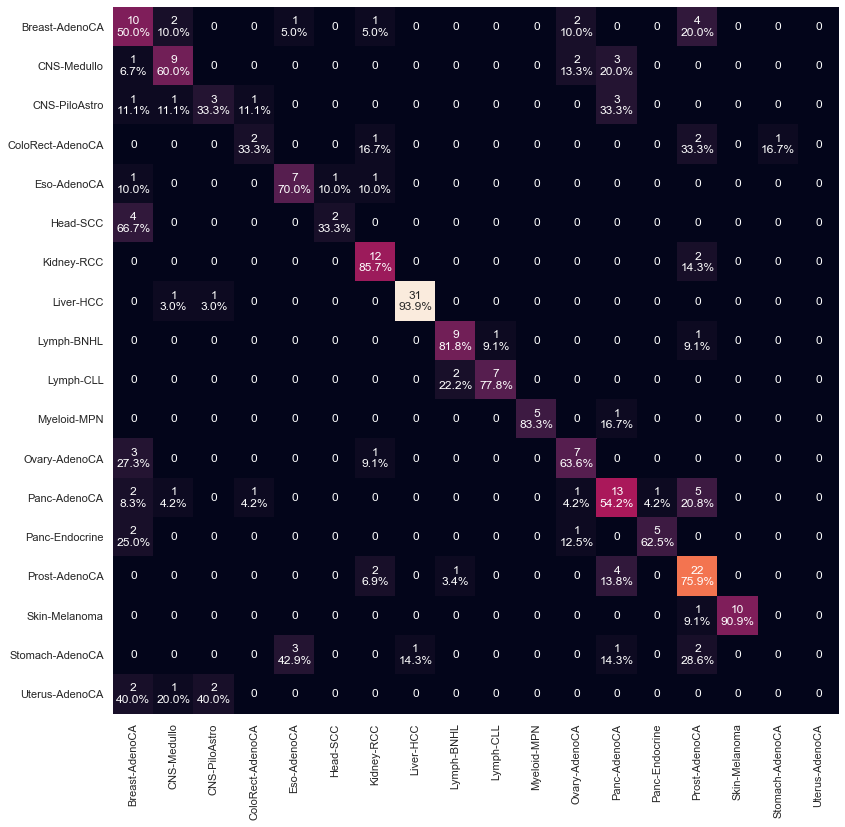

WGS_sub
Validation Accuracy: 0.7674786917521105
Test Accuracy: 0.7680412371134021


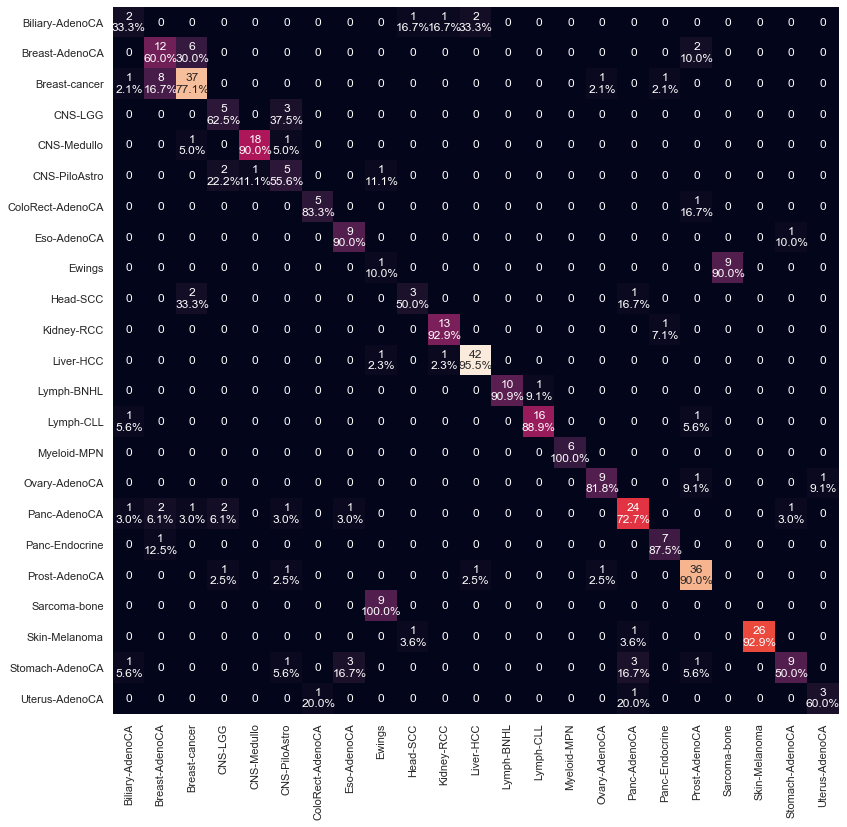

WGS_sub_sixchan
Validation Accuracy: 0.5418158616414974
Test Accuracy: 0.5180412371134021


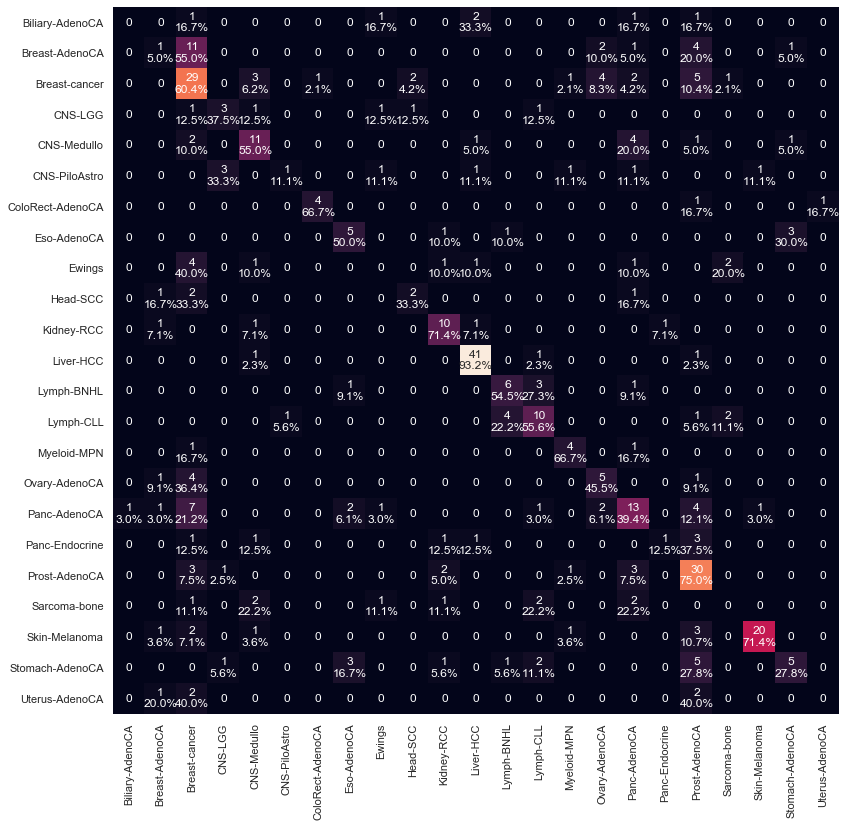

In [159]:
dataset_names = ['PCAWG_sub', 'PCAWG_sub_sixchan', 'WGS_sub', 'WGS_sub_sixchan']
for name in dataset_names:
    print(name)
    print("Validation Accuracy:", val_accs[name])
    print("Test Accuracy:", test_accs[name])
    confusion_matrix_plot(cmats[name], labels[name])

From the results above, using six channels instead of 96 channels reduce info available vastly and classification quality suffers a lot from that.  
From exploration so far, as for data from WGS, the best result can be obtained by using 96 channels without signature activity data.  
However, using dimension reduction algorithm, result might improve on dataset with signature activity data.  
  
Now, we start working on WES.